In [1]:
import torch
import time

In [2]:
n = 1000
a = torch.ones(n)
b = torch.ones(n)

In [3]:
a

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [4]:

class Timer(object):
    """记录多次运行时间"""
    def __init__(self):
        self.times = list()
        self.start()
    
    def start(self):
        self.start_time = time.time()
    
    def stop(self):
        self.times.append(time.time() - self.start_time)
        return self.times[-1]
    
    def avg(self):
        return sum(self.times)/len(self.times)
    
    def sum(self):
        return sum(self.times)

In [5]:
timer = Timer()
c = torch.zeros(n)
for i in range(n):
    c[i] = a[i] + b[i]
'%.5f sec' % timer.stop()

'0.04609 sec'

In [6]:
timer.start()
d = a + b
'%.5f sec' % timer.stop()

'0.00043 sec'

#### 结果很明显，后者比前者运算速度更快。

## 线性回归模型从零开始实现

In [7]:
%matplotlib inline
import torch
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import random

In [8]:
print(torch.__version__)

1.3.1+cpu


#### 生成数据集
使用线性模型来生成数据集，生成一个1000个样本的数据集

In [9]:
num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2
# 使用torch的随机函数，生成1000个样本，每个样本有两个数
features = torch.randn(num_examples, num_inputs,
                      dtype=torch.float32)
# 生成标签，现在生成的标签符合完全线性关系，但是真实世界中不存在完全符合线性关系的标签
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# 所以在这里通过正态分布随机生成数作为偏差加进去
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),dtype=torch.float32)

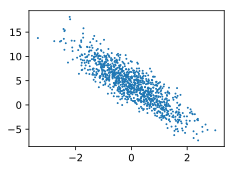

In [10]:
def use_svg_display():
    display.set_matplotlib_formats('svg')
    
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize


set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)
plt.show()

In [11]:
# 读取数据集
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 打乱数据的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i+batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)

In [12]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.4748, -0.1550],
        [-0.7302,  0.5626],
        [ 1.1789, -0.4199],
        [ 1.5258,  0.8876],
        [ 0.3794,  1.6384],
        [ 0.6865, -0.2616],
        [ 1.7974, -0.3193],
        [ 0.4144, -0.6493],
        [-0.3337, -0.5438],
        [-0.1376,  1.7429]]) 
 tensor([ 3.7764,  0.8263,  7.9884,  4.2142, -0.6001,  6.4527,  8.8934,  7.2260,
         5.3734, -1.9961])


## 初始化模型参数

In [13]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

## 定义模型

In [14]:
def linreg(X, w, b):
    return torch.mm(X, w) + b


## 定义损失函数

In [15]:
def squared_loss(y_hat, y):
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 定义优化函数

In [16]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

## 训练

In [17]:
lr = 0.03
num_epochs = 5
net = linreg
# 均方误差损失函数
loss = squared_loss
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        # 计算损失l
        l = loss(net(X, w, b), y).sum()
        l.backward()
        # 参数，学习率
        sgd([w, b], lr, batch_size)
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.034979
epoch 2, loss 0.000145
epoch 3, loss 0.000051
epoch 4, loss 0.000050
epoch 5, loss 0.000050


In [18]:
w,true_w, b,true_b

(tensor([[ 1.9999],
         [-3.4003]], requires_grad=True),
 [2, -3.4],
 tensor([4.1998], requires_grad=True),
 4.2)

## 线性回归模型使用pytorch的简洁实现

In [19]:
import torch
from torch import nn
import numpy as np
torch.manual_seed(1)
print(torch.__version__)

torch.set_default_tensor_type('torch.FloatTensor')

1.3.1+cpu


In [20]:
num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [21]:
import torch.utils.data as Data
batch_size = 10

dataset = Data.TensorDataset(features, labels)

data_iter = Data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

for X, y in data_iter:
    print(X, '\n', y)
    break

tensor([[ 0.2359,  0.5506],
        [-1.5756, -0.1290],
        [ 0.5278, -1.2606],
        [-0.5667, -0.7471],
        [-0.1828,  1.1634],
        [ 0.1300,  1.6940],
        [-0.3351,  0.6943],
        [-0.4918, -0.7093],
        [ 1.3370,  1.4727],
        [ 1.6065,  0.2474]]) 
 tensor([ 2.8005,  1.4896,  9.5557,  5.6173, -0.1310, -1.2921,  1.1810,  5.6550,
         1.8657,  6.5819])


In [22]:
class LinearNet(nn.Module):
    
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
        
    def forward(self, x):
        y = self.linear(x)
        return y
    
net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [23]:
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
)

# methid twi
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))

# method three
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
    ('linear', nn.Linear(num_inputs, 1))
]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


## 初始化模型参数

In [24]:
from torch.nn import init

init.normal_(net[0].weight, mean=0.0, std=0.01)
init.constant_(net[0].bias, val=0.0)

Parameter containing:
tensor([0.], requires_grad=True)

In [25]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.0142, -0.0161]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


## 定义损失函数

In [26]:
loss = nn.MSELoss()

## 定义优化函数

In [27]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [28]:
# 循环3次
num_epochs = 3
for epoch in range(1, num_epochs+1):
    # 从data_iter取数据
    for X, y in data_iter:
        # 把数据集放进网络，得到预测值y
        output = net(X)
        # 把预测值y和真实值y放进损失函数计算
        l = loss(output, y.view(-1, 1))
        # 梯度清零,防止进行累加
        optimizer.zero_grad()
        # 进行反向传播，计算梯度
        l.backward()
        # 使用优化函数进行迭代优化
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000244
epoch 2, loss: 0.000138
epoch 3, loss: 0.000122


In [29]:
dense = net[0]
print(true_w, dense.weight.data)
print(true_b, dense.bias.data)

[2, -3.4] tensor([[ 1.9994, -3.4008]])
4.2 tensor([4.2005])
